### Functions and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def noise_pow(ω, ω_c, κ, r, g, Q, Δ, nc, nT):
    """
    function for calculating the noise power spectrum per equation 2 in Kurt's paper
    :param ω:      frequency offset from the cavity frequency
    :param ω_c:    frequency of the cavity
    :param κ:      output coupling rate of cavity
    :param r:      effective cooling rate term
    :param g:      collective interaction between spins and cavity
    :param Q:      quality factor of cavity
    :param Δ:      detuning
    :param nc:     number of photons in the cold spin ensemble
    :param nT:     number of photons in the thermal mode
    :returns:      the noise power at ω
    """
    a = nc - nT
    num = κ * r * g ** 2
    den_b = ((r ** 2 / 4) + ω ** 2) * ((κ + ω_c / Q) ** 2 / 4 + (ω - Δ) ** 2)
    den_c = (r * (κ + ω_c / Q) / 2 - 2 * ω * (ω - Δ))

    return nT + a * num / (den_b + g ** 2 * den_c + g ** 4)

In [4]:
def mean_photons_cavity(κ, ω_c, Q, r, g, nT, nc):
    """
    function for calculating the steady state photon number in the cavity per equation 98 in Kurt's supplemental info document
    """
    num = (κ + ω_c / Q) * nT + r * g ** 2 / ((r/2)**2 + (r/2)*((κ+ω_c / Q) / 2) + g ** 2) * nc
    den = (κ + ω_c / Q) + r * g ** 2 / ((r/2)**2 + (r/2)*((κ+ω_c / Q) / 2) + g ** 2)
    return num / den

In [5]:
def temp_from_photons(ω_c, num_photons):
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω_c / np.log(1 / num_photons + 1)

In [6]:
def photons_from_temp(ω_c, temp):
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω_c / temp) - 1) ** -1

## T = 77 K, Q = 10, 000

### Set up and miscellaneous testing

In [7]:
# Define parameters.  According to Ethan, Q = 10,000 @ T = 77 K and g_j = 1 Hz at minimum
κ = 0
ω = 0                                           
ωc = 2.87 * 2 * np.pi * 1e9        
hbar_ov_k = 7.639e-12   
Q = 1e4
T = 77
γ = ωc / Q 
P = 0.8

In [8]:
# Sweep over values of g now
g = np.logspace(7, 9, 10000)
r = g.copy()

In [9]:
# Calculate the number of photons
nc = 0.5 * (1 - P) / P
nT = photons_from_temp(ωc, T)

In [10]:
nT

558.4752332974967

In [11]:
Np_v_g = noise_pow(ω, ωc, κ, r, g, Q, 0, nc, nT)
T_v_g = hbar_ov_k * ωc * 2 * np.pi / np.log(1 / Np_v_g + 1)
nbar_v_g = mean_photons_cavity(κ, ωc, Q, g, g, nT, nc)

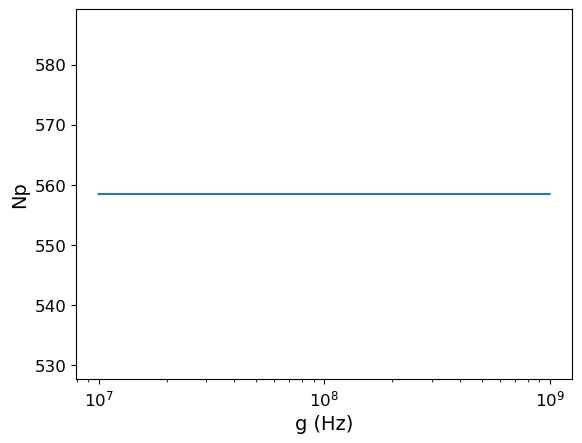

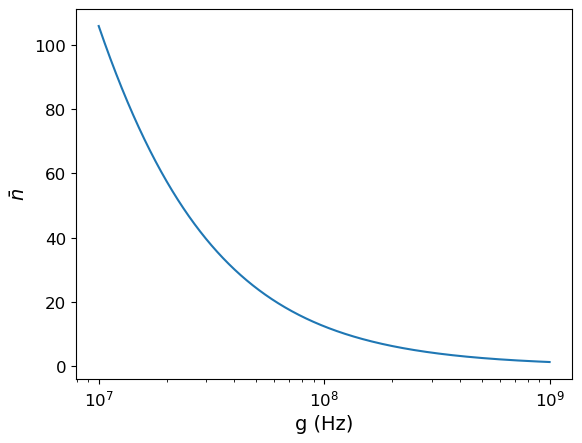

In [12]:
plt.figure(1)
plt.plot(g, Np_v_g)
plt.xlabel("g (Hz)")
plt.ylabel("Np")
plt.xscale('log')
plt.savefig("Np_v_g_κ=0_T=77K_P=0.8.png", format='png', dpi=300)

plt.figure(2)
plt.plot(g, nbar_v_g)
plt.xlabel("g (Hz)")
plt.ylabel("$\\bar{n}$")
plt.xscale('log')
plt.savefig("n_v_g_κ=0_T=77K_P=0.8.png", format='png', dpi=300)

### Sweep over parameters

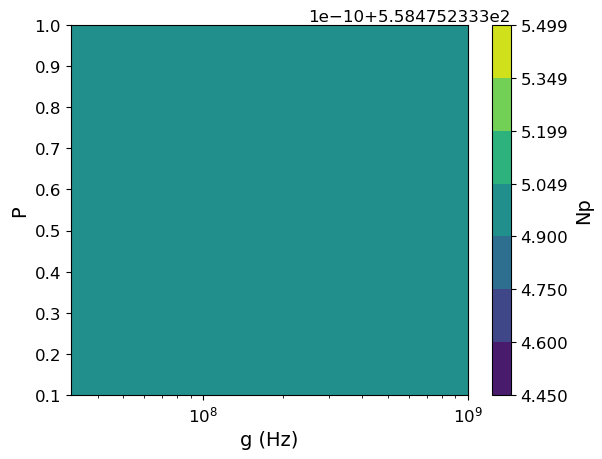

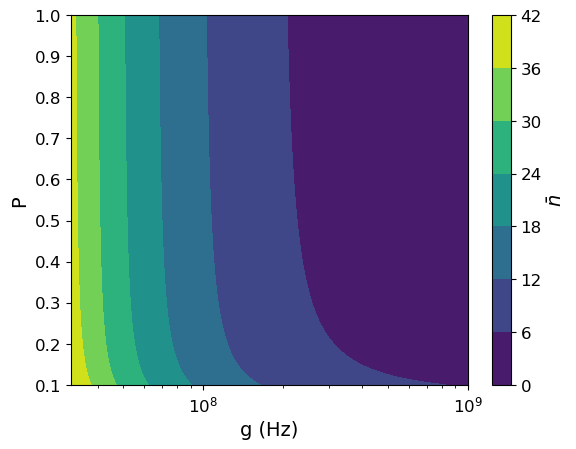

In [13]:
# Let's try sweeping over a couple of different parameters with g to see what we can find.  We'll keep Q fixed for now
# First let's do P
g = np.logspace(7.5, 9, 10000)
P_sweep = np.linspace(0.1, 1, 1000)
nc_sweep = 0.5 * (1 - P_sweep) / P_sweep

gm, ncm = np.meshgrid(g, nc_sweep)
Np_P_sweep = noise_pow(ω, ωc, κ, gm, gm, Q, 0, ncm, nT)
plt.figure(1)
plt.contourf(gm, 1 / (1 + 2 * ncm), Np_P_sweep)
plt.xlabel("g (Hz)")
plt.ylabel("P")
plt.xscale('log')
plt.colorbar(label='Np')
plt.savefig("Np_gP_sweep_κ=0_T=77K.png", format='png', dpi=300)

nbar_P_sweep = mean_photons_cavity(κ, ωc, Q, gm, gm, nT, ncm) 
plt.figure(2)
plt.contourf(gm, 1 / (1 + 2 * ncm), nbar_P_sweep)
plt.xlabel("g (Hz)")
plt.ylabel("P")
plt.xscale('log')
plt.colorbar(label='$\\bar{n}$')
plt.savefig("n_gP_sweep_κ=0_T=77K.png", format='png', dpi=300)

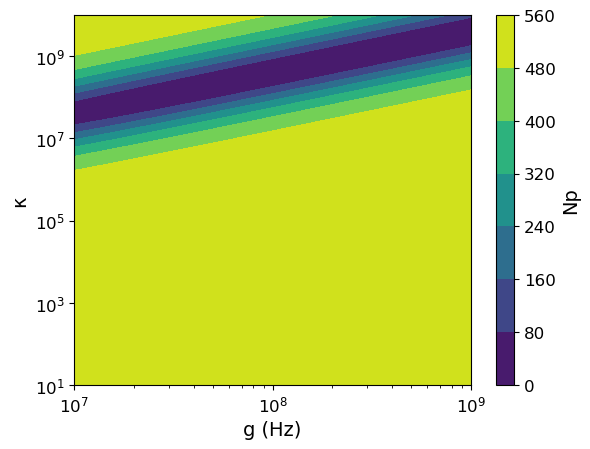

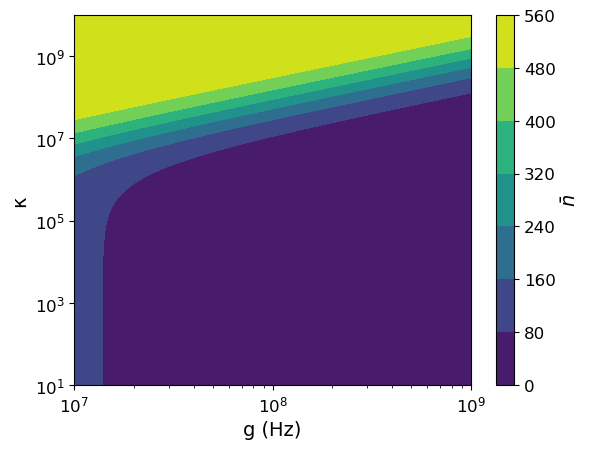

In [14]:
# Now let's do κ
g = np.logspace(7, 9, 10000)
κ_sweep = np.logspace(1, 10, 1000)

gm, κm = np.meshgrid(g, κ_sweep)
Np_κ_sweep = noise_pow(ω, ωc, κm, gm, gm, Q, 0, nc, nT)
plt.figure(1)
plt.contourf(gm, κm, Np_κ_sweep)
plt.xlabel("g (Hz)")
plt.ylabel("κ")
plt.yscale('log')
plt.xscale('log')
plt.colorbar(label='Np')
plt.savefig("Np_gκ_sweep_P=0.8_T=77K.png", format='png', dpi=300)

nbar_κ_sweep = mean_photons_cavity(κm, ωc, Q, gm, gm, nT, nc) 
plt.figure(2)
plt.contourf(gm, κm, nbar_κ_sweep)
plt.xlabel("g (Hz)")
plt.ylabel("κ")
plt.yscale('log')
plt.xscale('log')
plt.colorbar(label='$\\bar{n}$')
plt.savefig("n_gκ_sweep_P=0.8_T=77K.png", format='png', dpi=300)

## T = 5 K, Q = 25, 000

### Setup

In [15]:
# Now what if the initial temperature is 5 K?  According to Ethan, then Q = 25,000
κ = 0
ω = 0                                           
ωc = 2.87 * 2 * np.pi * 1e9        
hbar_ov_k = 7.639e-12   
Q = 2.5e4
T = 5
γ = ωc / Q 
P = 0.8

In [16]:
# Sweep over values of g now
g = np.logspace(7, 9, 10000)
r = g.copy()

In [17]:
# Calculate the number of photons
nc = 0.5 * (1 - P) / P
nT = (np.exp(hbar_ov_k * ωc / T) - 1) ** -1

In [18]:
Np_v_g = noise_pow(ω, ωc, κ, r, g, Q, 0, nc, nT)
T_v_g = hbar_ov_k * ωc * 2 * np.pi / np.log(1 / Np_v_g + 1)
nbar_v_g = mean_photons_cavity(κ, ωc, Q, g, g, nT, nc)

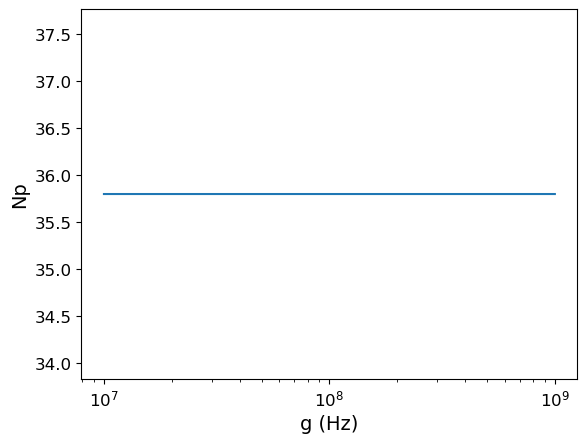

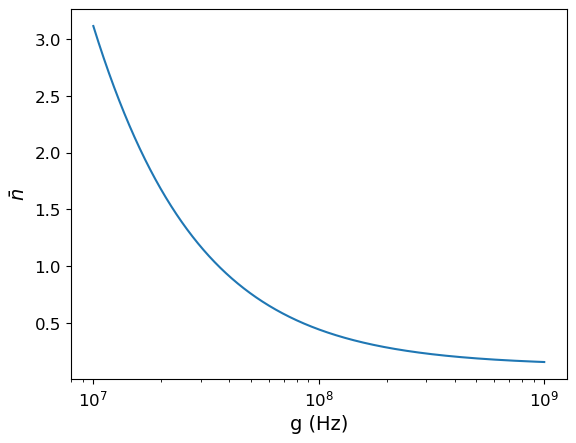

In [19]:
plt.figure(1)
plt.plot(g, Np_v_g)
plt.xlabel("g (Hz)")
plt.xscale('log')
plt.ylabel("Np")
plt.savefig("Np_v_g_κ=0_T=5K_P=0.8.png", format='png', dpi=300)

plt.figure(2)
plt.plot(g, nbar_v_g)
plt.xlabel("g (Hz)")
plt.xscale('log')
plt.ylabel("$\\bar{n}$")
plt.savefig("n_v_g_κ=0_T=5K_P=0.8.png", format='png', dpi=300)

### Sweep over parameters

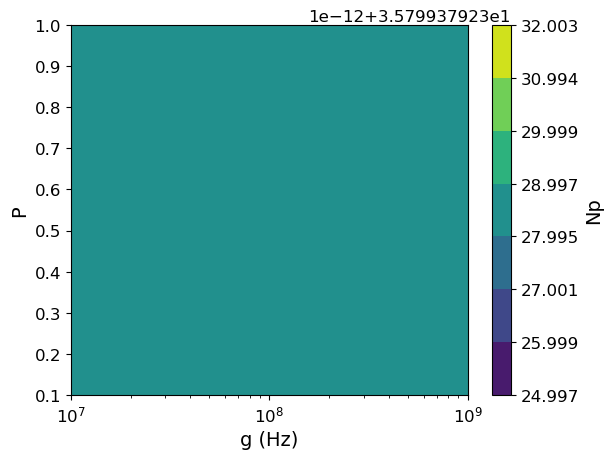

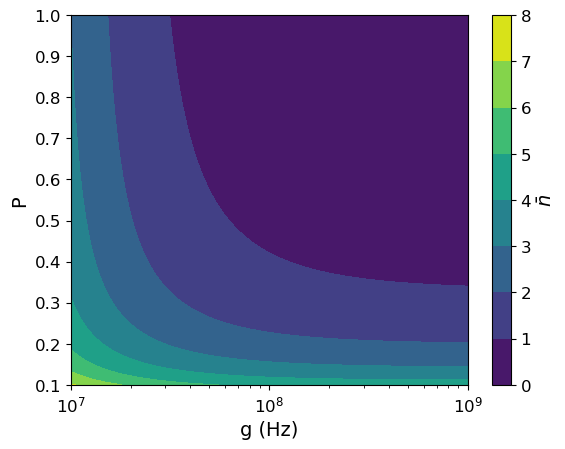

In [20]:
g = np.logspace(7, 9, 10000)
P_sweep = np.linspace(0.1, 1, 1000)
nc_sweep = 0.5 * (1 - P_sweep) / P_sweep

gm, ncm = np.meshgrid(g, nc_sweep)
Np_P_sweep = noise_pow(ω, ωc, κ, gm, gm, Q, 0, ncm, nT)
plt.figure(1)
plt.contourf(gm, 1 / (1 + 2 * ncm), Np_P_sweep)
plt.xlabel("g (Hz)")
plt.xscale("log")
plt.ylabel("P")
plt.colorbar(label='Np')
plt.savefig("Np_gP_sweep_κ=0_T=5K.png", format='png', dpi=300)

nbar_P_sweep = mean_photons_cavity(κ, ωc, Q, gm, gm, nT, ncm) 
plt.figure(2)
plt.contourf(gm, 1 / (1 + 2 * ncm), nbar_P_sweep)
plt.xlabel("g (Hz)")
plt.xscale("log")
plt.ylabel("P")
plt.colorbar(label='$\\bar{n}$')
plt.savefig("n_gP_sweep_κ=0_T=5K.png", format='png', dpi=300)

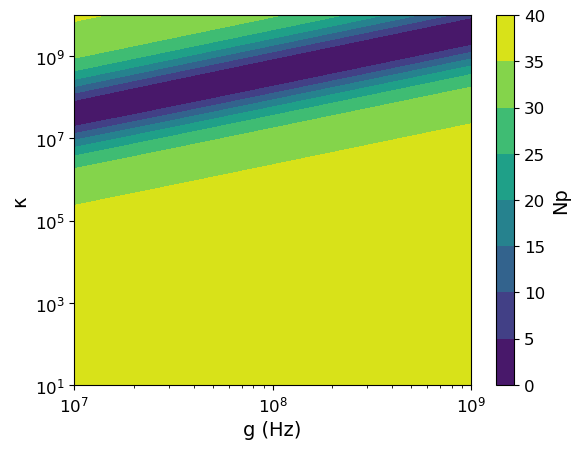

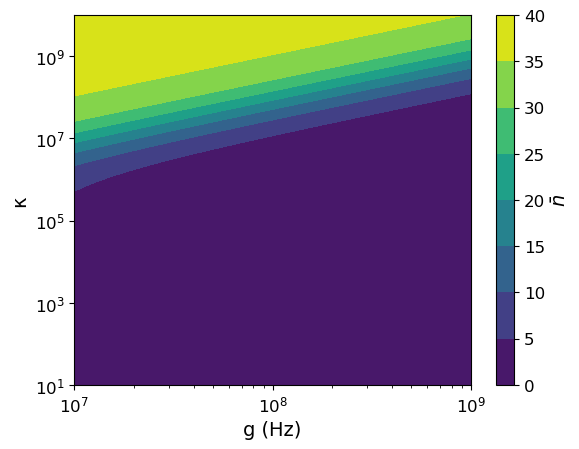

In [21]:
# Now let's do κ
g = np.logspace(7, 9, 10000)
κ_sweep = np.logspace(1, 10, 1000)

gm, κm = np.meshgrid(g, κ_sweep)
Np_κ_sweep = noise_pow(ω, ωc, κm, gm, gm, Q, 0, nc, nT)
plt.figure(1)
plt.contourf(gm, κm, Np_κ_sweep)
plt.xlabel("g (Hz)")
plt.ylabel("κ")
plt.yscale('log')
plt.xscale('log')
plt.colorbar(label='Np')
plt.savefig("Np_gκ_sweep_P=0.8_T=5K.png", format='png', dpi=300)

nbar_κ_sweep = mean_photons_cavity(κm, ωc, Q, gm, gm, nT, nc) 
plt.figure(2)
plt.contourf(gm, κm, nbar_κ_sweep)
plt.xlabel("g (Hz)")
plt.ylabel("κ")
plt.yscale('log')
plt.xscale('log')
plt.colorbar(label='$\\bar{n}$')
plt.savefig("n_gκ_sweep_P=0.8_T=5K.png", format='png', dpi=300)

In [22]:
# Fidelity of the final state with the ideal ground state
# Noise (mode) temperature vs base temperature for a given cavity setup

## Miscellaneous

What is required for the cavities to reach < 1 photon for each base temperature?  From previous results, we can see that we'll probably need g > 10 MHz.  Let's for now assume an ideal case of $P = 1, \kappa = 0$.  We'll still use $r = g$ for now as well

Currently, these figures are all presented in terms of $g$, but it's probably better to have them in terms of more physical parameters.  We know that $g = \sqrt{N}$ where $N$ is the number of spins in the NV ensemble.  This is going to depend on the number of NV spins in the crystal, which should be given as a density

In [23]:
# We have 2 situations
T1, Q1 = 77, 1e4
T2, Q2 = 5, 2.5e4
T3, Q3 = 300, 1 / 1.4e-4
κ = 0
P = 1
ωc = 2.87 * 2 * np.pi * 1e9
g = np.logspace(7, 10, 10000)
N = g ** 2

In [24]:
nT1 = photons_from_temp(ωc, T1)
nT2 = photons_from_temp(ωc, T2)
nT3 = photons_from_temp(ωc, T3)
nc = 0.5 * (1 - P) / P

In [25]:
nT1, nT2, nT3

(558.4752332974967, 35.79937923012842, 2177.3250416999917)

In [26]:
n1 = mean_photons_cavity(κ, ωc, Q1, g, g, nT1, nc)
n2 = mean_photons_cavity(κ, ωc, Q2, g, g, nT2, nc)
n3 = mean_photons_cavity(κ, ωc, Q3, g, g, nT3, nc)

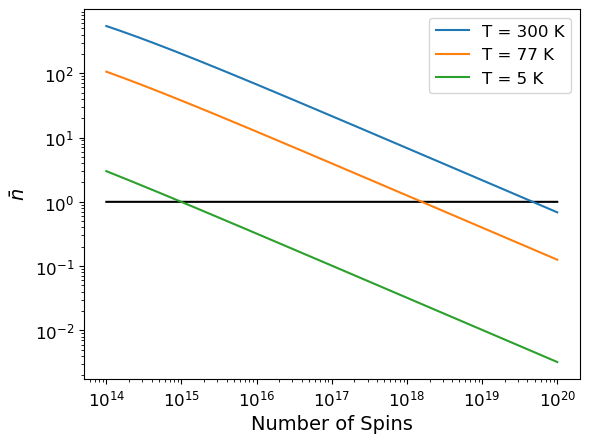

In [27]:
plt.plot(N, np.ones(N.size), 'k-')
plt.plot(N, n3, label='T = 300 K')
plt.plot(N, n1, label='T = 77 K')
plt.plot(N, n2, label='T = 5 K')
plt.xlabel("Number of Spins")
plt.xscale('log')
plt.ylabel("$\\bar{n}$")
plt.yscale('log')
plt.legend()

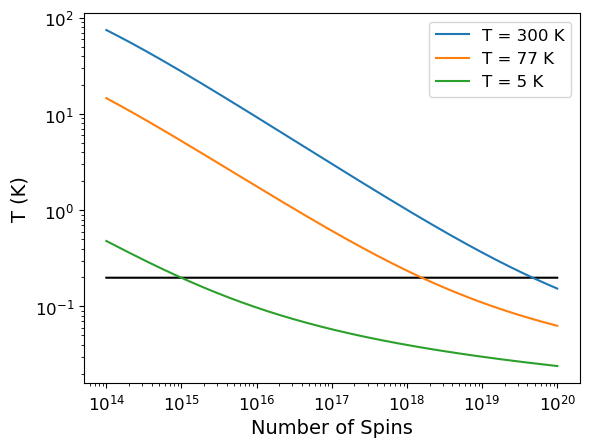

In [28]:
# In terms of mode temperatures, we get
t1 = temp_from_photons(ωc, n1)
t2 = temp_from_photons(ωc, n2)
t3 = temp_from_photons(ωc, n3)
plt.plot(N, temp_from_photons(ωc, np.ones(g.size)), 'k-')
plt.plot(N, t3, label='T = 300 K')
plt.plot(N, t1, label='T = 77 K')
plt.plot(N, t2, label='T = 5 K')
plt.xlabel("Number of Spins")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("T (K)")
plt.legend()

In [29]:
# In terms of fidelity with the ground (i.e. zero) state
f1 = 1 / (1 + n1)
f2 = 1 / (1 + n2)
f3 = 1 / (1 + n3)

In [30]:
print(f1[-1], n1[-1] / (1 + n1[-1]) ** 2)

0.888208588235799 0.09929409201996792


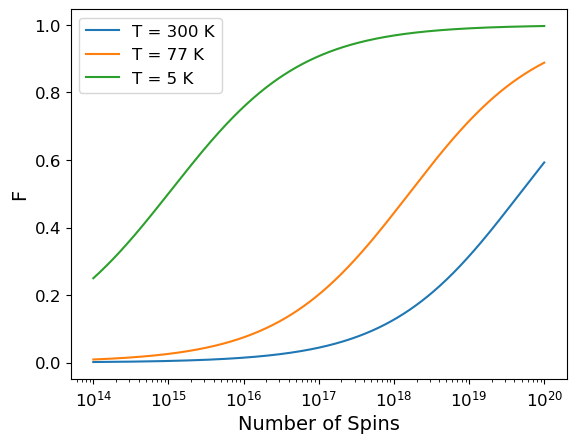

In [31]:
#plt.plot(g, temp_from_photons(ωc, np.ones(g.size)), 'k-')
plt.plot(N, f3, label='T = 300 K')
plt.plot(N, f1, label='T = 77 K')
plt.plot(N, f2, label='T = 5 K')
plt.xlabel("Number of Spins")
plt.xscale('log')
plt.ylabel("F")
plt.legend()

In [32]:
# So both are able to get to below nbar = 1, but perhaps at some unreasonable values of g
g1 = g[n1 <= 1][0]
g2 = g[n2 <= 1][0]
g3 = g[n3 <= 1][0]
print(g1 / 1e6, g2 / 1e6, g3 / 1e6)

1257.7952809647152 31.52462034306898 6872.008822285523


What if you had a fixed value of $g$?  What values of $P$ and $\kappa$ are required to reach $\bar{n} < 1$?

In [33]:
g1, g2, g3 = 1e7, 1e8, 1e9
P = np.linspace(0.1, 1, 100)
nc = 0.5 * (1 - P) / P
κ = np.linspace(0, 1000, 10000)

In [34]:
n1_p_g1 = mean_photons_cavity(0, ωc, Q1, g1, g1, nT1, nc)
n2_p_g1 = mean_photons_cavity(0, ωc, Q2, g1, g1, nT2, nc)
n3_p_g1 = mean_photons_cavity(0, ωc, Q3, g1, g1, nT3, nc)

n1_p_g2 = mean_photons_cavity(0, ωc, Q1, g2, g2, nT1, nc)
n2_p_g2 = mean_photons_cavity(0, ωc, Q2, g2, g2, nT2, nc)
n3_p_g2 = mean_photons_cavity(0, ωc, Q3, g2, g2, nT3, nc)

n1_p_g3 = mean_photons_cavity(0, ωc, Q1, g3, g3, nT1, nc)
n2_p_g3 = mean_photons_cavity(0, ωc, Q2, g3, g3, nT2, nc)
n3_p_g3 = mean_photons_cavity(0, ωc, Q3, g3, g3, nT3, nc)

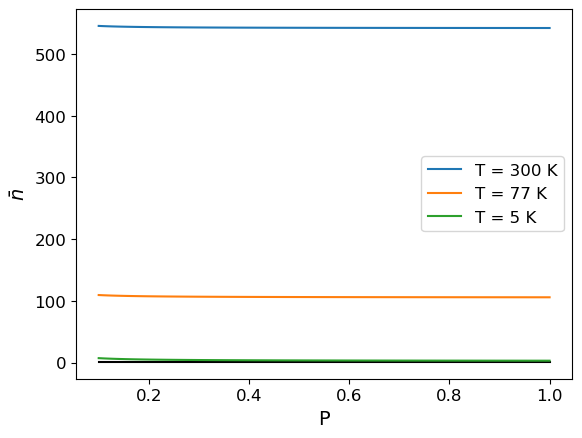

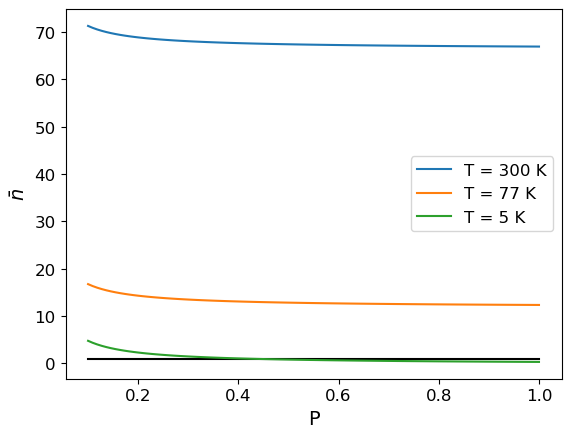

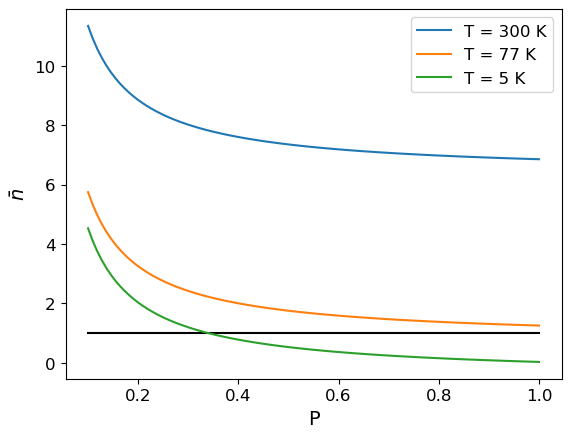

In [35]:
plt.figure(1)
plt.plot(P, np.ones(P.size), 'k-')
plt.plot(P, n3_p_g1, label='T = 300 K')
plt.plot(P, n1_p_g1, label='T = 77 K')
plt.plot(P, n2_p_g1, label='T = 5 K')
plt.xlabel("P")
plt.ylabel("$\\bar{n}$")
plt.legend()

plt.figure(2)
plt.plot(P, np.ones(P.size), 'k-')
plt.plot(P, n3_p_g2, label='T = 300 K')
plt.plot(P, n1_p_g2, label='T = 77 K')
plt.plot(P, n2_p_g2, label='T = 5 K')
plt.xlabel("P")
plt.ylabel("$\\bar{n}$")
plt.legend()

plt.figure(3)
plt.plot(P, np.ones(P.size), 'k-')
plt.plot(P, n3_p_g3, label='T = 300 K')
plt.plot(P, n1_p_g3, label='T = 77 K')
plt.plot(P, n2_p_g3, label='T = 5 K')
plt.xlabel("P")
plt.ylabel("$\\bar{n}$")
plt.legend()

In [36]:
# In terms of mode temperatures, we get
t1_p_g1 = temp_from_photons(ωc, n1_p_g1)
t2_p_g1 = temp_from_photons(ωc, n2_p_g1)
t3_p_g1 = temp_from_photons(ωc, n3_p_g1)

t1_p_g2 = temp_from_photons(ωc, n1_p_g2)
t2_p_g2 = temp_from_photons(ωc, n2_p_g2)
t3_p_g2 = temp_from_photons(ωc, n3_p_g2)

t1_p_g3 = temp_from_photons(ωc, n1_p_g3)
t2_p_g3 = temp_from_photons(ωc, n2_p_g3)
t3_p_g3 = temp_from_photons(ωc, n3_p_g3)

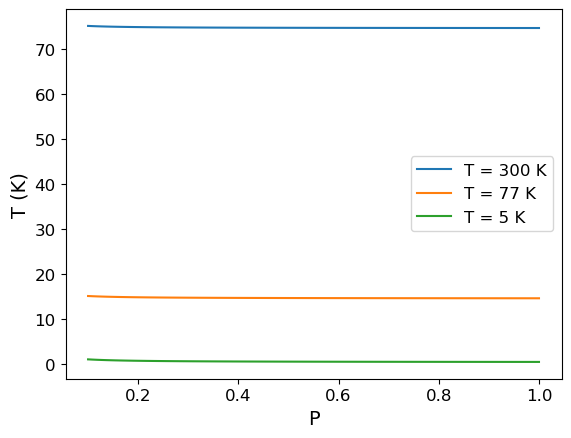

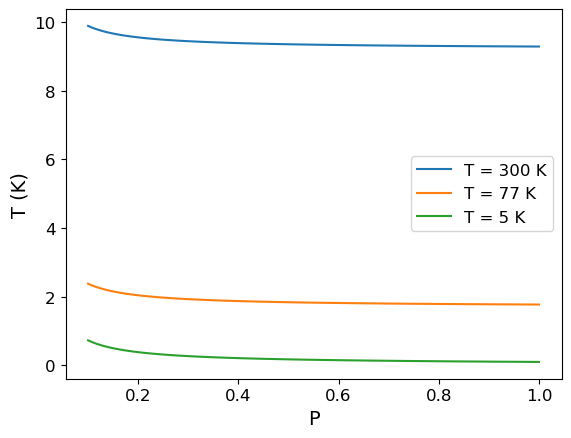

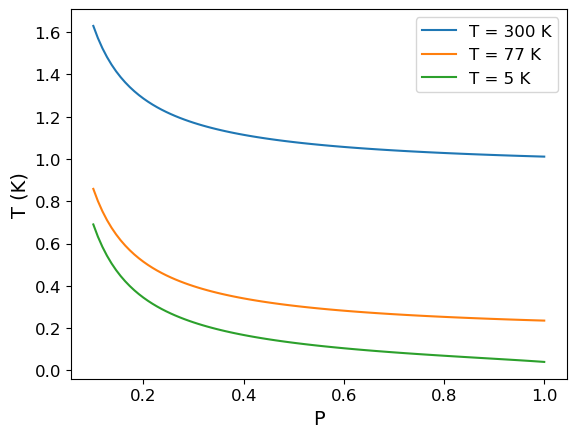

In [37]:
plt.figure(1)
plt.plot(P, t3_p_g1, label='T = 300 K')
plt.plot(P, t1_p_g1, label='T = 77 K')
plt.plot(P, t2_p_g1, label='T = 5 K')
plt.xlabel("P")
plt.ylabel("T (K)")
plt.legend()

plt.figure(2)
plt.plot(P, t3_p_g2, label='T = 300 K')
plt.plot(P, t1_p_g2, label='T = 77 K')
plt.plot(P, t2_p_g2, label='T = 5 K')
plt.xlabel("P")
plt.ylabel("T (K)")
plt.legend()

plt.figure(3)
plt.plot(P, t3_p_g3, label='T = 300 K')
plt.plot(P, t1_p_g3, label='T = 77 K')
plt.plot(P, t2_p_g3, label='T = 5 K')
plt.xlabel("P")
plt.ylabel("T (K)")
plt.legend()

In [38]:
# In terms of fidelity with the ground (i.e. zero) state
f1_p_g1 = 1 / (1 + n1_p_g1)
f2_p_g1 = 1 / (1 + n2_p_g1)
f3_p_g1 = 1 / (1 + n3_p_g1)

f1_p_g2 = 1 / (1 + n1_p_g2)
f2_p_g2 = 1 / (1 + n2_p_g2)
f3_p_g2 = 1 / (1 + n3_p_g2)

f1_p_g3 = 1 / (1 + n1_p_g3)
f2_p_g3 = 1 / (1 + n2_p_g3)
f3_p_g3 = 1 / (1 + n3_p_g3)

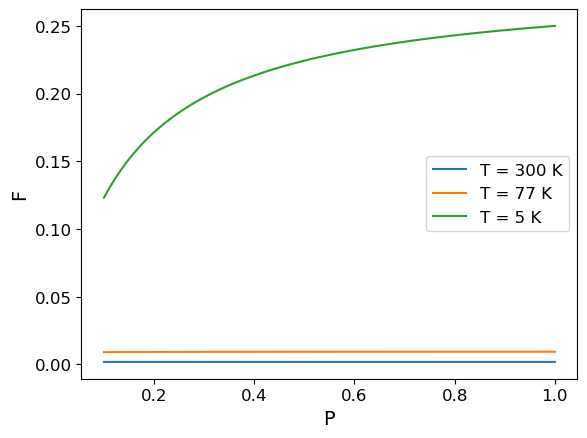

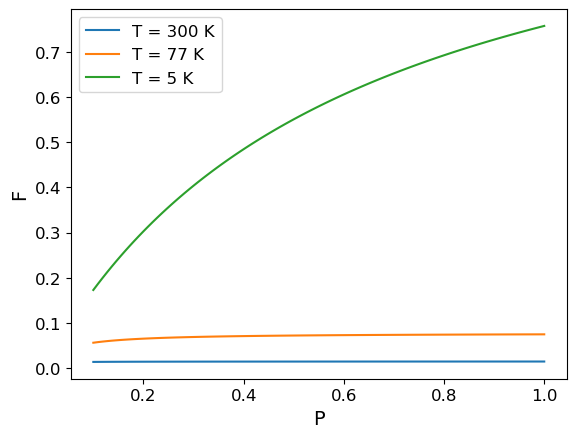

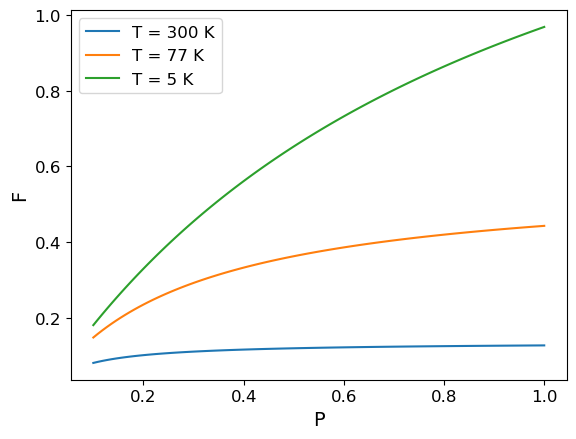

In [39]:
plt.figure(1)
plt.plot(P, f3_p_g1, label='T = 300 K')
plt.plot(P, f1_p_g1, label='T = 77 K')
plt.plot(P, f2_p_g1, label='T = 5 K')
plt.xlabel("P")
plt.ylabel("F")
plt.legend()

plt.figure(2)
plt.plot(P, f3_p_g2, label='T = 300 K')
plt.plot(P, f1_p_g2, label='T = 77 K')
plt.plot(P, f2_p_g2, label='T = 5 K')
plt.xlabel("P")
plt.ylabel("F")
plt.legend()

plt.figure(3)
plt.plot(P, f3_p_g3, label='T = 300 K')
plt.plot(P, f1_p_g3, label='T = 77 K')
plt.plot(P, f2_p_g3, label='T = 5 K')
plt.xlabel("P")
plt.ylabel("F")
plt.legend()

In [40]:
n1_k_g1 = mean_photons_cavity(κ, ωc, Q1, g1, g1, nT1, 0)
n2_k_g1 = mean_photons_cavity(κ, ωc, Q2, g1, g1, nT2, 0)
n3_k_g1 = mean_photons_cavity(κ, ωc, Q3, g1, g1, nT3, 0)

n1_k_g2 = mean_photons_cavity(κ, ωc, Q1, g2, g2, nT1, 0)
n2_k_g2 = mean_photons_cavity(κ, ωc, Q2, g2, g2, nT2, 0)
n3_k_g2 = mean_photons_cavity(κ, ωc, Q3, g2, g2, nT3, 0)

n1_k_g3 = mean_photons_cavity(κ, ωc, Q1, g3, g3, nT1, 0)
n2_k_g3 = mean_photons_cavity(κ, ωc, Q2, g3, g3, nT2, 0)
n3_k_g3 = mean_photons_cavity(κ, ωc, Q3, g3, g3, nT3, 0)

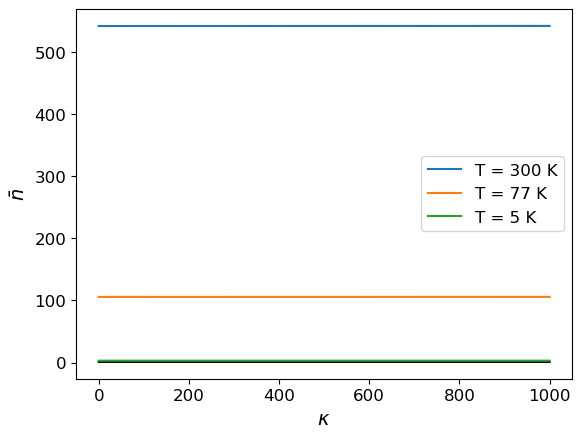

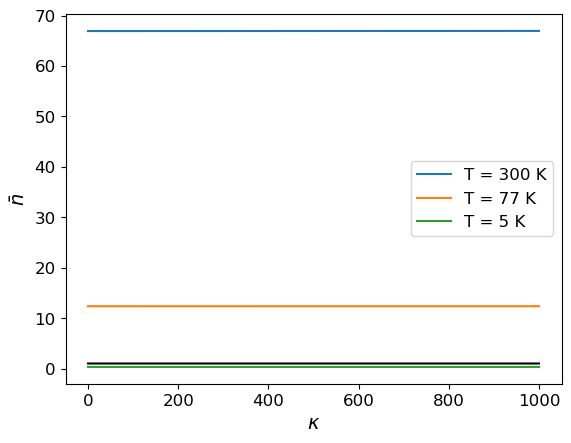

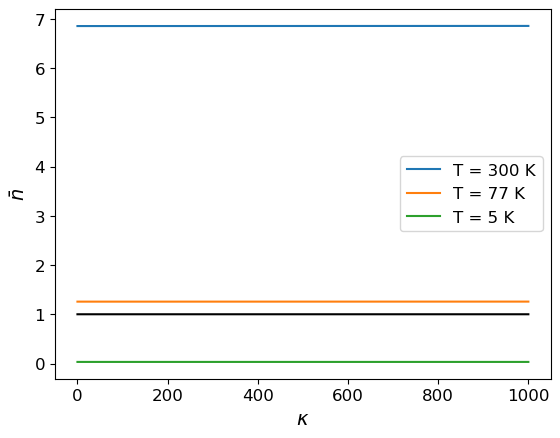

In [41]:
plt.figure(1)
plt.plot(κ, np.ones(κ.size), 'k-')
plt.plot(κ, n3_k_g1, label='T = 300 K')
plt.plot(κ, n1_k_g1, label='T = 77 K')
plt.plot(κ, n2_k_g1, label='T = 5 K')
plt.xlabel("$\\kappa$")
plt.ylabel("$\\bar{n}$")
plt.legend()

plt.figure(2)
plt.plot(κ, np.ones(κ.size), 'k-')
plt.plot(κ, n3_k_g2, label='T = 300 K')
plt.plot(κ, n1_k_g2, label='T = 77 K')
plt.plot(κ, n2_k_g2, label='T = 5 K')
plt.xlabel("$\\kappa$")
plt.ylabel("$\\bar{n}$")
plt.legend()

plt.figure(3)
plt.plot(κ, np.ones(κ.size), 'k-')
plt.plot(κ, n3_k_g3, label='T = 300 K')
plt.plot(κ, n1_k_g3, label='T = 77 K')
plt.plot(κ, n2_k_g3, label='T = 5 K')
plt.xlabel("$\\kappa$")
plt.ylabel("$\\bar{n}$")
plt.legend()

In [42]:
# In terms of mode temperatures, we get
t1_k_g1 = temp_from_photons(ωc, n1_k_g1)
t2_k_g1 = temp_from_photons(ωc, n2_k_g1)
t3_k_g1 = temp_from_photons(ωc, n3_k_g1)

t1_k_g2 = temp_from_photons(ωc, n1_k_g2)
t2_k_g2 = temp_from_photons(ωc, n2_k_g2)
t3_k_g2 = temp_from_photons(ωc, n3_k_g2)

t1_k_g3 = temp_from_photons(ωc, n1_k_g3)
t2_k_g3 = temp_from_photons(ωc, n2_k_g3)
t3_k_g3 = temp_from_photons(ωc, n3_k_g3)

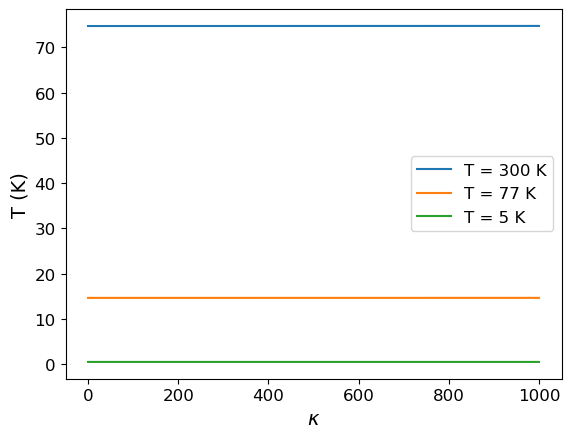

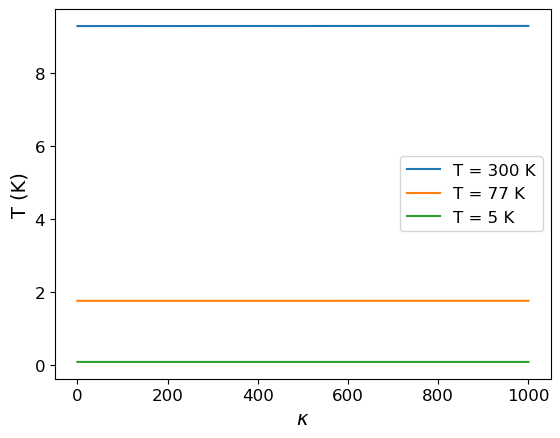

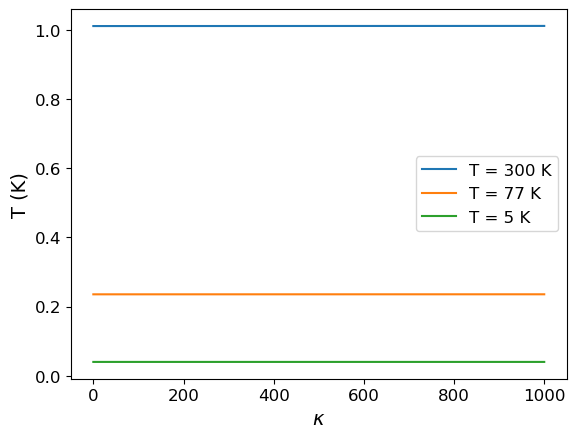

In [43]:
plt.figure(1)
plt.plot(κ, t3_k_g1, label='T = 300 K')
plt.plot(κ, t1_k_g1, label='T = 77 K')
plt.plot(κ, t2_k_g1, label='T = 5 K')
plt.xlabel("$\\kappa$")
plt.ylabel("T (K)")
plt.legend()

plt.figure(2)
plt.plot(κ, t3_k_g2, label='T = 300 K')
plt.plot(κ, t1_k_g2, label='T = 77 K')
plt.plot(κ, t2_k_g2, label='T = 5 K')
plt.xlabel("$\\kappa$")
plt.ylabel("T (K)")
plt.legend()

plt.figure(3)
plt.plot(κ, t3_k_g3, label='T = 300 K')
plt.plot(κ, t1_k_g3, label='T = 77 K')
plt.plot(κ, t2_k_g3, label='T = 5 K')
plt.xlabel("$\\kappa$")
plt.ylabel("T (K)")
plt.legend()

In [44]:
# In terms of fidelity with the ground (i.e. zero) state
f1_k_g1 = 1 / (1 + n1_k_g1)
f2_k_g1 = 1 / (1 + n2_k_g1)
f3_k_g1 = 1 / (1 + n3_k_g1)

f1_k_g2 = 1 / (1 + n1_k_g2)
f2_k_g2 = 1 / (1 + n2_k_g2)
f3_k_g2 = 1 / (1 + n3_k_g2)

f1_k_g3 = 1 / (1 + n1_k_g3)
f2_k_g3 = 1 / (1 + n2_k_g3)
f3_k_g3 = 1 / (1 + n3_k_g3)

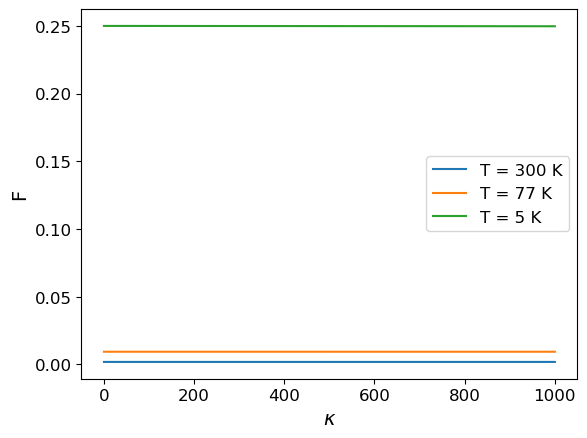

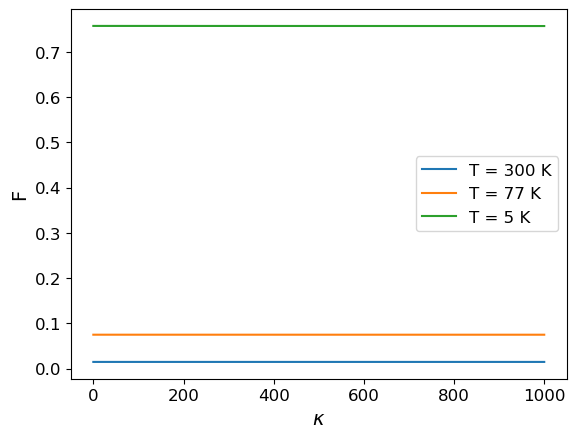

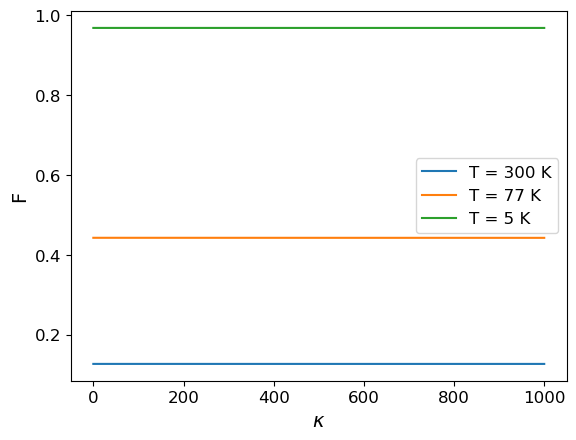

In [45]:
plt.figure(1)
plt.plot(κ, f3_k_g1, label='T = 300 K')
plt.plot(κ, f1_k_g1, label='T = 77 K')
plt.plot(κ, f2_k_g1, label='T = 5 K')
plt.xlabel("$\\kappa$")
plt.ylabel("F")
plt.legend()

plt.figure(2)
plt.plot(κ, f3_k_g2, label='T = 300 K')
plt.plot(κ, f1_k_g2, label='T = 77 K')
plt.plot(κ, f2_k_g2, label='T = 5 K')
plt.xlabel("$\\kappa$")
plt.ylabel("F")
plt.legend()

plt.figure(3)
plt.plot(κ, f3_k_g3, label='T = 300 K')
plt.plot(κ, f1_k_g3, label='T = 77 K')
plt.plot(κ, f2_k_g3, label='T = 5 K')
plt.xlabel("$\\kappa$")
plt.ylabel("F")
plt.legend()

### What happens if $r \neq g$?

In [46]:
# We have 2 situations
T1, Q1 = 77, 1e4
T2, Q2 = 5, 2.5e4
κ = 0
P = 1
ωc = 2.87 * 2 * np.pi * 1e9
g = np.logspace(7, 11, 10000)
r = np.logspace(1, 11, 10000)

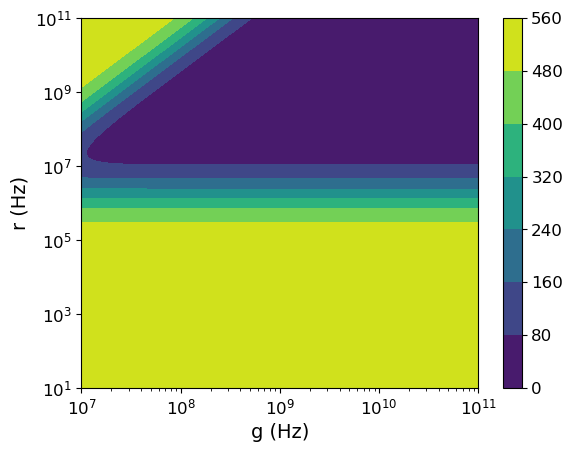

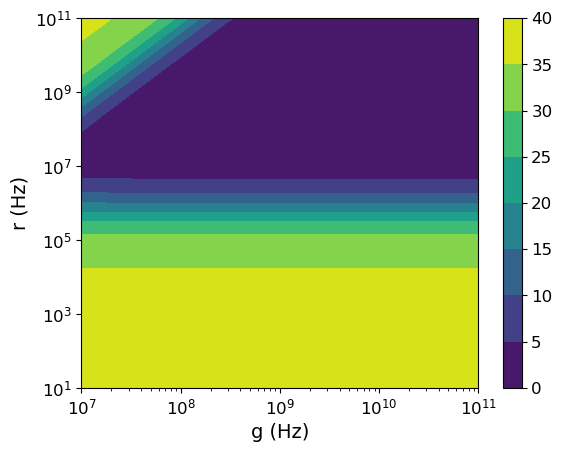

In [47]:
gm, rm = np.meshgrid(g, r)
n_rg_sweep_T1 = mean_photons_cavity(κ, ωc, Q1, rm, gm, nT1, 0)
n_rg_sweep_T2 = mean_photons_cavity(κ, ωc, Q2, rm, gm, nT2, 0)
plt.figure(1)
plt.contourf(gm, rm, n_rg_sweep_T1)
plt.colorbar()
plt.xlabel("g (Hz)")
plt.xscale('log')
plt.ylabel("r (Hz)")
plt.yscale('log')

plt.figure(2)
plt.contourf(gm, rm, n_rg_sweep_T2)
plt.colorbar()
plt.xlabel("g (Hz)")
plt.xscale('log')
plt.ylabel("r (Hz)")
plt.yscale('log')

So $r \sim g$ for best performance